# Mini-project for D7041E
Alex Bergdahl - alxber-0@student.ltu.se<br/>
Linus Håkegård - linhke-0@student.ltu.se

## Import dataset and define model variables

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

epochs = 4
num_layers_list = [1, 2, 3] # number of layers including input but not output
layer_sizes_list = [[(256,), (512,), (1024,)], [(256, 256), (512, 512), (1024, 1024)], [(256, 256, 256), (512, 512, 512), (1024, 1024, 1024)]]

## Train the models

### Set up the training and testing data

In [12]:
torch.manual_seed(0)
batch_size_train = 64
batch_size_test = 128

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size_test, shuffle=False)

### Define the neural network models

In [13]:
class Cross_Entropy_Model(nn.Module):
    def __init__(self, num_hidden_layers, hidden_layer_sizes):
        super(Cross_Entropy_Model, self).__init__()
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layers = nn.ModuleList()

        # Input layer
        self.hidden_layers.append(nn.Linear(28 * 28, hidden_layer_sizes[0]))

        # Hidden layers
        for i in range(num_hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i + 1]))

        self.output_layer = nn.Linear(hidden_layer_sizes[-1], 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        
        # Pass through hidden layers
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        
        x = self.output_layer(x)
        return x

class NLL_model(nn.Module):
    def __init__(self, num_hidden_layers, hidden_layer_sizes):
        super(NLL_model, self).__init__()
        self.num_hidden_layers = num_hidden_layers
        self.hidden_layers = nn.ModuleList()

        # Input layer
        self.hidden_layers.append(nn.Linear(28 * 28, hidden_layer_sizes[0]))

        # Hidden layers
        for i in range(num_hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i + 1]))

        self.output_layer = nn.Linear(hidden_layer_sizes[-1], 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        
        # Pass through hidden layers
        for layer in self.hidden_layers:
            # x = torch.relu(layer(x))
            x = nn.functional.relu(layer(x))
        
        x = self.output_layer(x)
        return x

### Define the training functions

In [14]:
def train_cross_entropy_model(epochs, num_layers_list, layer_sizes_list):
    models = []
    criterion = nn.CrossEntropyLoss()
    print('Training cross entropy models')
    for num_hidden_layers, hidden_layer_sizes in zip(num_layers_list, layer_sizes_list):
        print(f'Number of hidden layers: {num_hidden_layers-1}, Hidden layer sizes: {hidden_layer_sizes}')
        for hidden_layer_size in hidden_layer_sizes:
            print(f'Current layer size: {hidden_layer_size}')
            model = Cross_Entropy_Model(num_hidden_layers, hidden_layer_size)
            optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

            for epoch in range(epochs):
                running_loss = 0.0
                for i, data in enumerate(trainloader, 0):
                    inputs, labels = data
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
                print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')
            
            models.append((model, num_hidden_layers, hidden_layer_size))
    return models

def train_NLL_model(epochs, num_layers_list, layer_sizes_list):
    models = []
    criterion = nn.NLLLoss()
    print('Training NLL models')
    for num_hidden_layers, hidden_layer_sizes in zip(num_layers_list, layer_sizes_list):
        print(f'Number of hidden layers: {num_hidden_layers-1}, Layer sizes: {hidden_layer_sizes}')
        for hidden_layer_size in hidden_layer_sizes:
            print(f'Layer sizes: {hidden_layer_sizes}')
            model = NLL_model(num_hidden_layers, hidden_layer_size)
            optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

            for epoch in range(epochs):
                running_loss = 0.0
                for i, data in enumerate(trainloader, 0):
                    inputs, labels = data
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    outputs = torch.nn.functional.log_softmax(outputs, dim=1)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
                print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')
            
            models.append((model, num_hidden_layers, hidden_layer_size))
    return models

### Train the models using cross entropy cost function

In [15]:
models_cross_entropy_loss = train_cross_entropy_model(epochs, num_layers_list, layer_sizes_list)
models_NLL = train_NLL_model(epochs, num_layers_list, layer_sizes_list)

Training cross entropy models
Number of hidden layers: 0, Hidden layer sizes: [(256,), (512,), (1024,)]
Current layer size: (256,)


Epoch 1, Loss: 0.7595179919590319
Epoch 2, Loss: 0.3652916431649407
Epoch 3, Loss: 0.3201100778366838
Epoch 4, Loss: 0.2944937484589086
Current layer size: (512,)
Epoch 1, Loss: 0.7187045403857475
Epoch 2, Loss: 0.3572286406813908
Epoch 3, Loss: 0.31483351039702195
Epoch 4, Loss: 0.287793981296612
Current layer size: (1024,)
Epoch 1, Loss: 0.6756866665473625
Epoch 2, Loss: 0.34926609695752037
Epoch 3, Loss: 0.3071440048674658
Epoch 4, Loss: 0.2791185201024577
Number of hidden layers: 1, Hidden layer sizes: [(256, 256), (512, 512), (1024, 1024)]
Current layer size: (256, 256)
Epoch 1, Loss: 0.9906493859377496
Epoch 2, Loss: 0.36883043796459497
Epoch 3, Loss: 0.3132457493035905
Epoch 4, Loss: 0.2829721921733193
Current layer size: (512, 512)
Epoch 1, Loss: 0.9323768130878904
Epoch 2, Loss: 0.36124319392544374
Epoch 3, Loss: 0.30820822619648375
Epoch 4, Loss: 0.27562987063326305
Current layer size: (1024, 1024)
Epoch 1, Loss: 0.8601200511968975
Epoch 2, Loss: 0.3493881813768766
Epoch 3, L

## Evaluate the models

### Define testing functions

In [16]:
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    
    accuracy = correct / total
    return all_labels, all_preds, accuracy

def evaluate_and_report(model, testloader, class_names):
    true_labels, predicted_labels, accuracy = evaluate_model(model, testloader)
    cm = confusion_matrix(true_labels, predicted_labels)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    return cm_df, accuracy

### Test the models

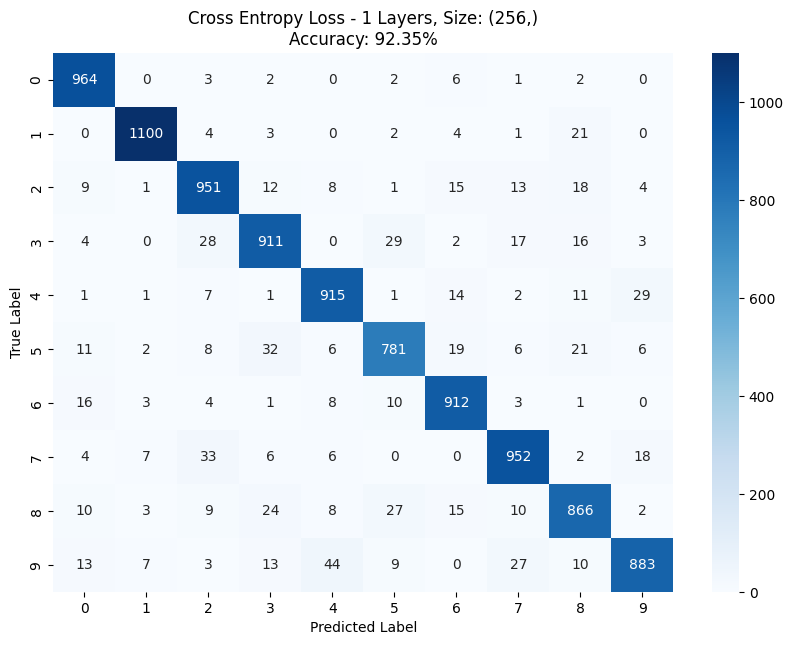

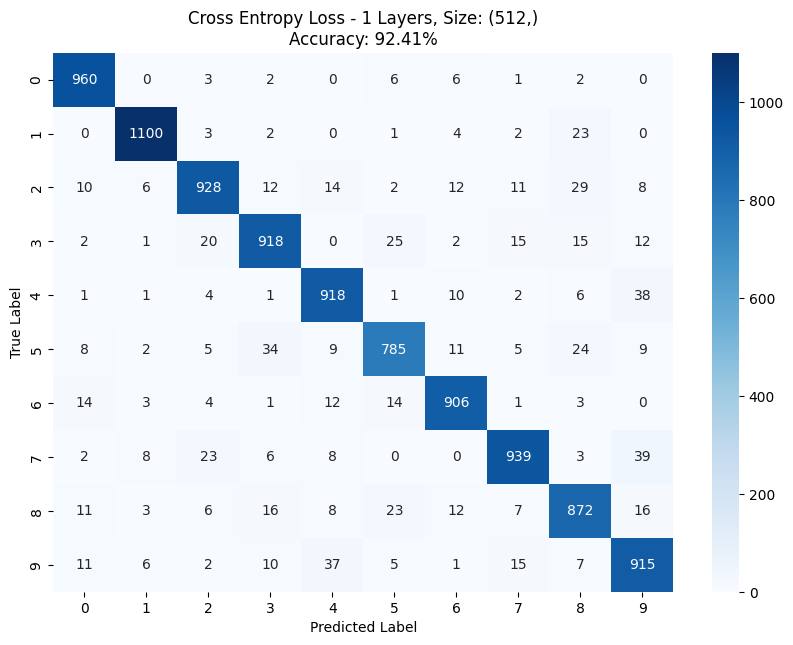

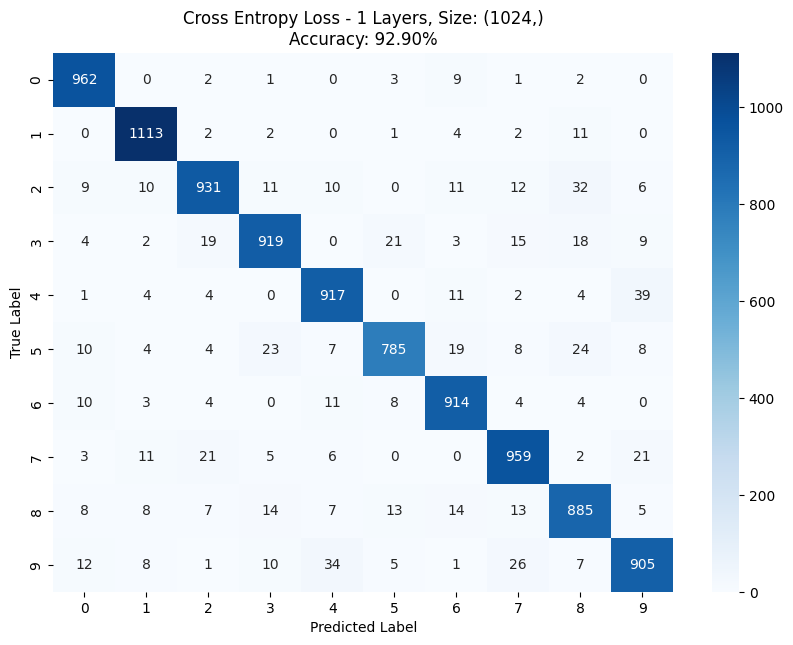

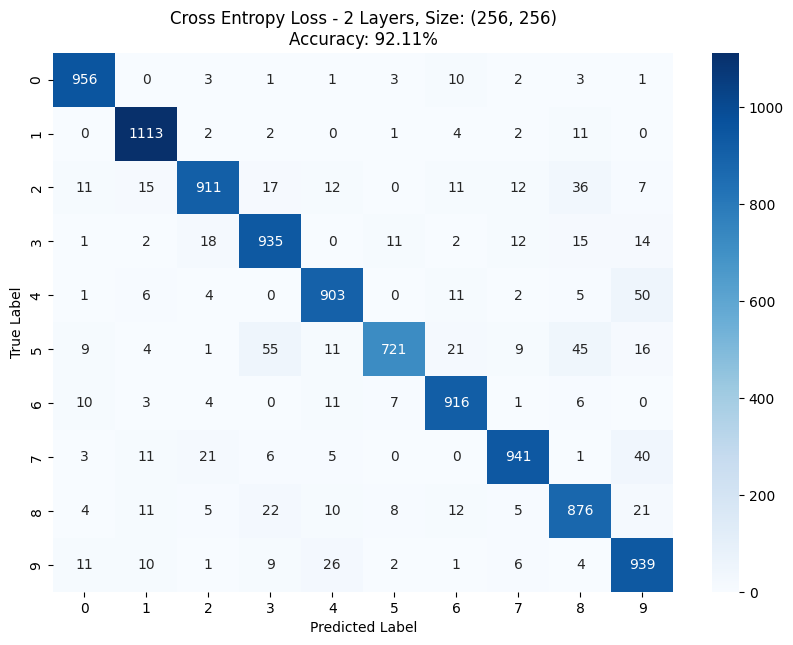

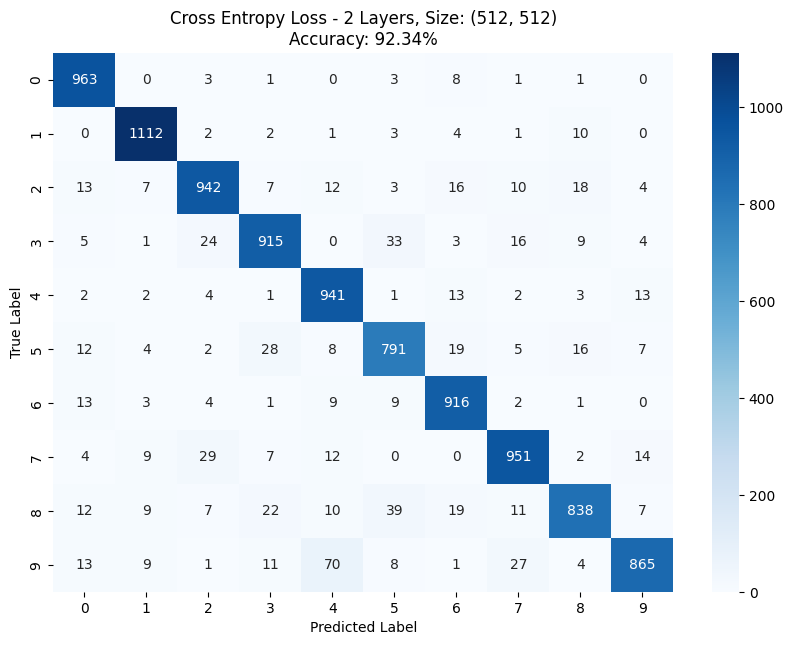

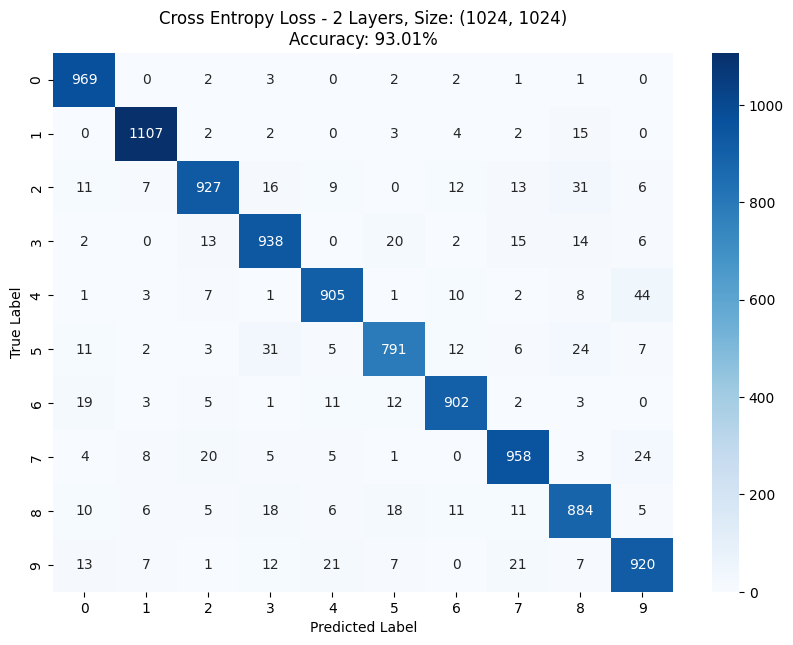

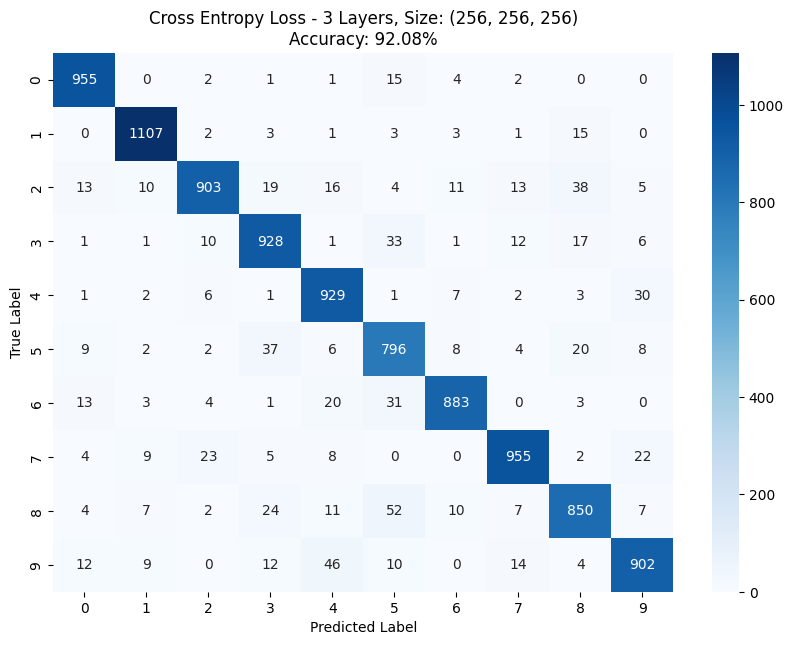

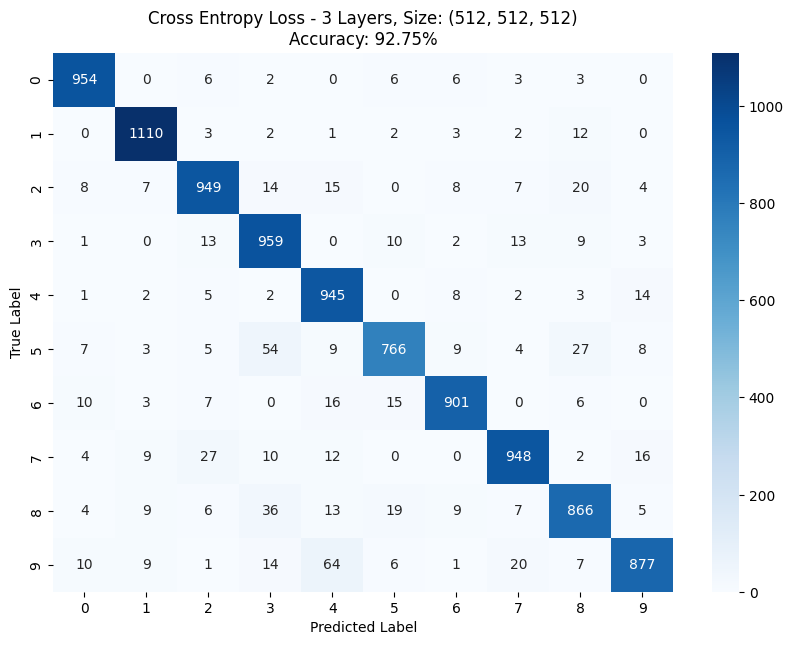

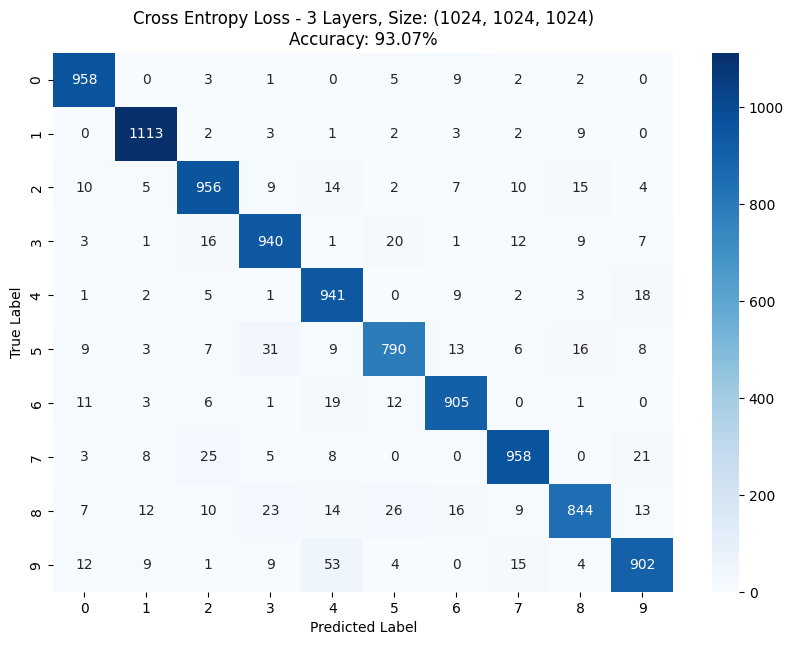

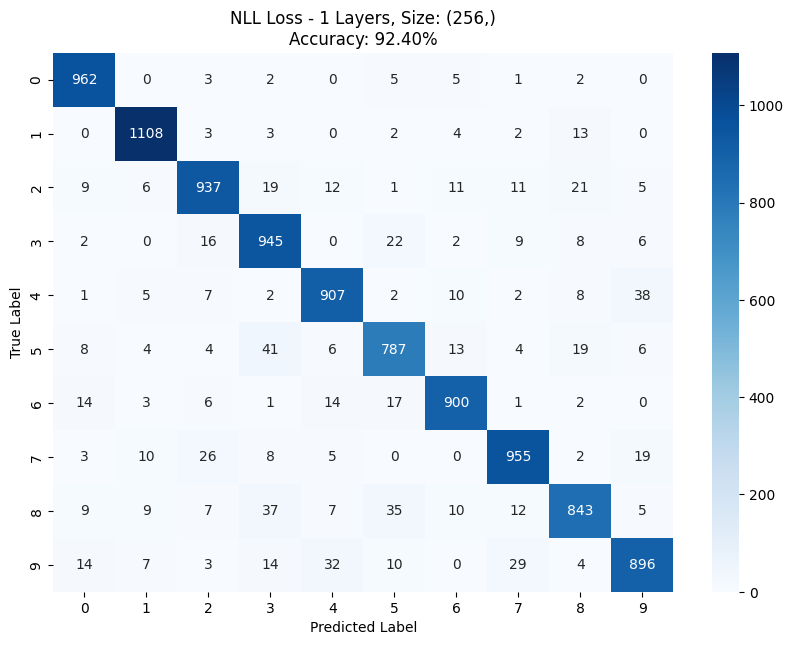

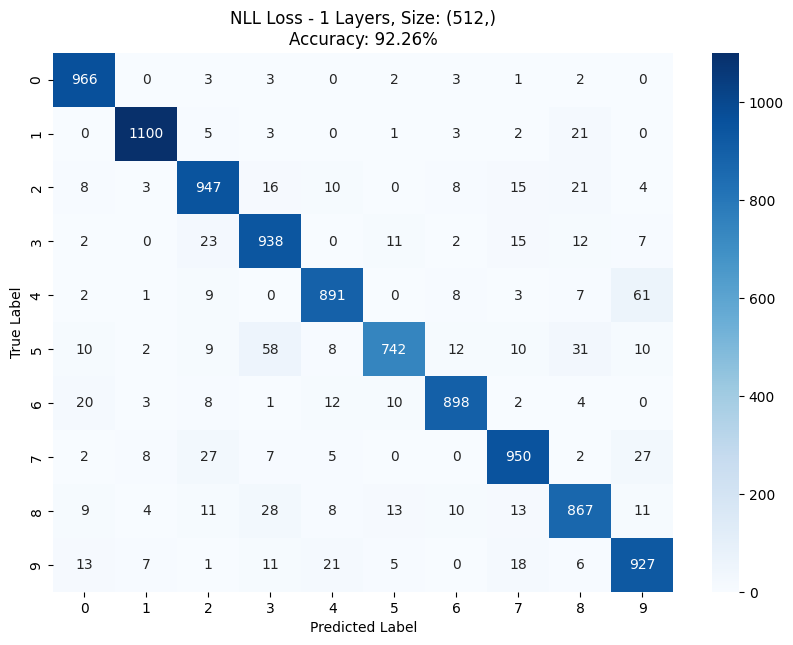

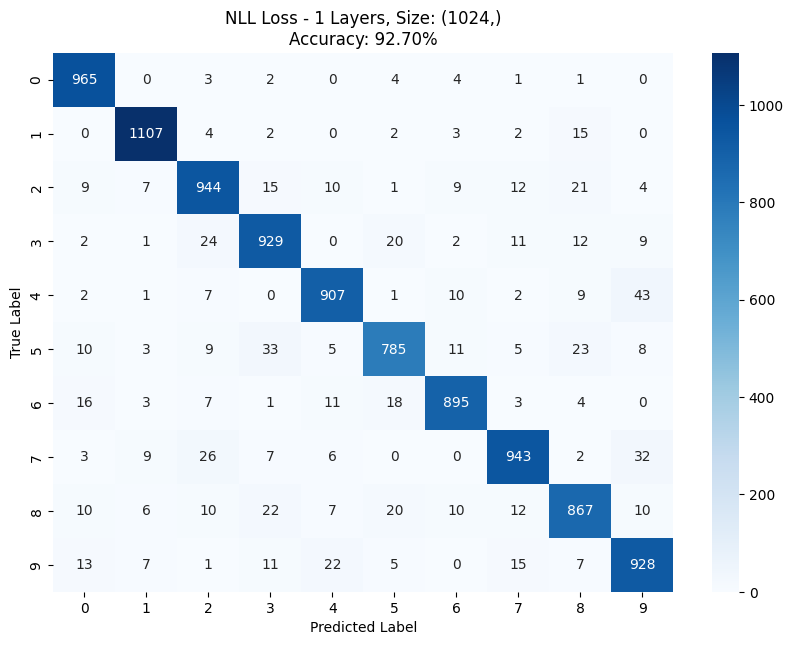

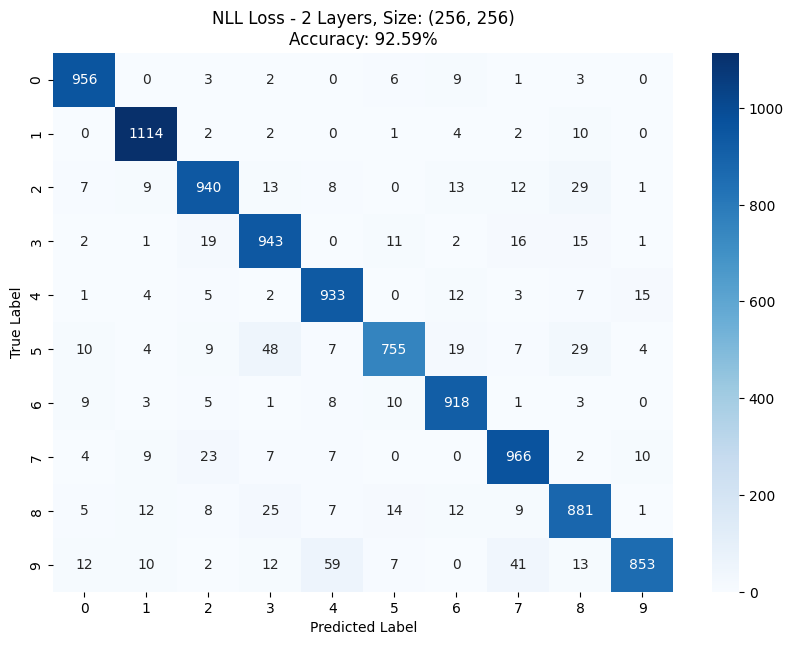

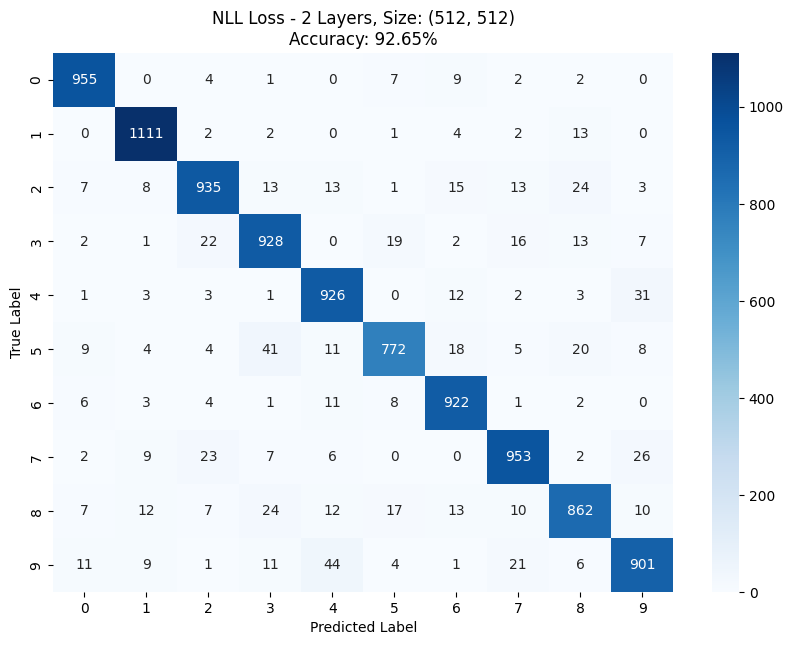

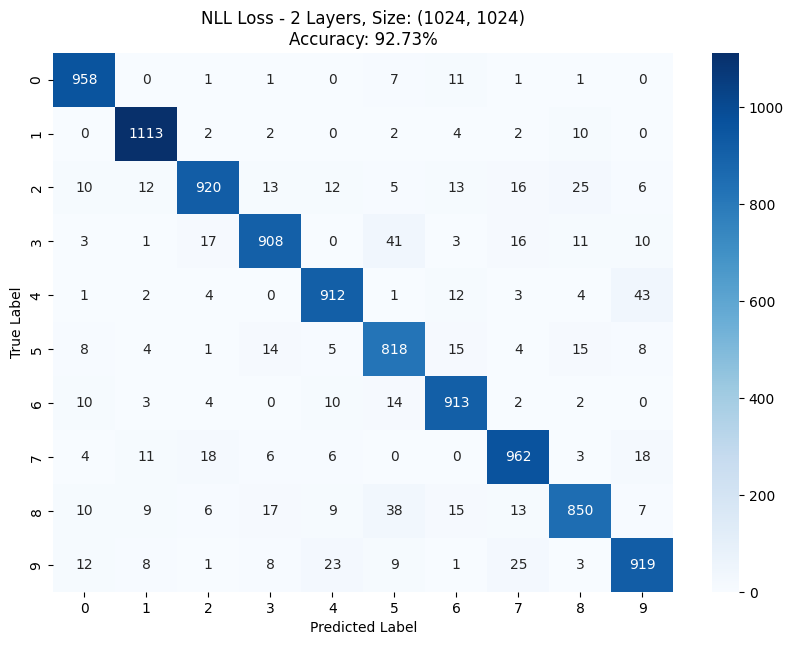

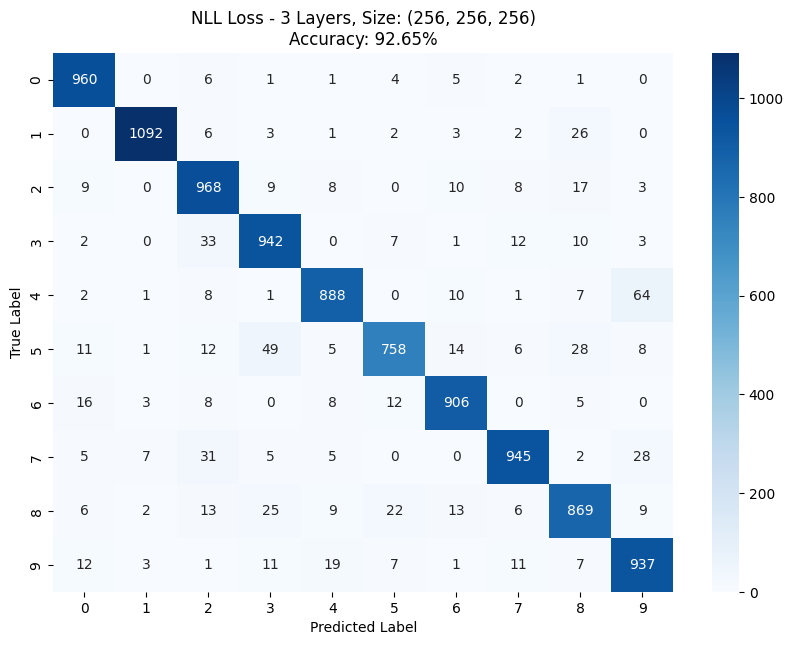

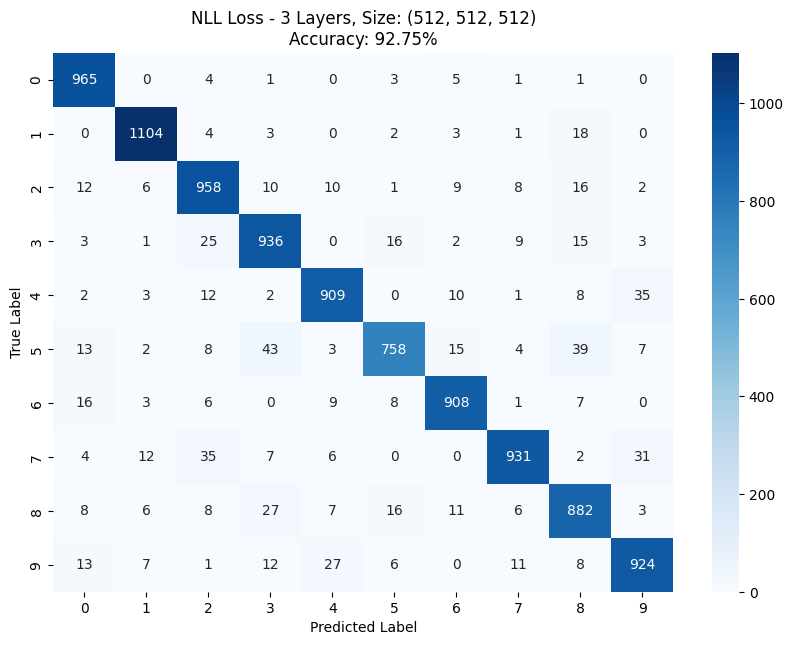

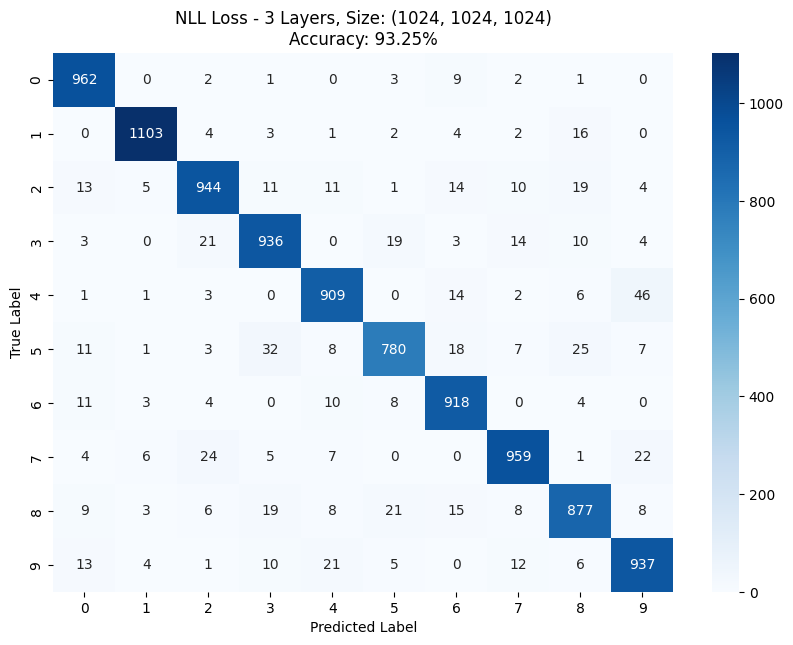

In [17]:
class_names = [str(i) for i in range(10)]

def plot_confusion_matrix(cm_df, accuracy, model_description):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
    plt.title(f'{model_description}\nAccuracy: {accuracy * 100:.2f}%')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# For Cross Entropy Models
for model, num_hidden_layers, hidden_layer_size in models_cross_entropy_loss:
    cm_df, accuracy = evaluate_and_report(model, testloader, class_names)
    model_description = f"Cross Entropy Loss - {num_hidden_layers} Layers, Size: {hidden_layer_size}"
    plot_confusion_matrix(cm_df, accuracy, model_description)

# For NLL Models
for model, num_hidden_layers, hidden_layer_size in models_NLL:
    cm_df, accuracy = evaluate_and_report(model, testloader, class_names)
    model_description = f"NLL Loss - {num_hidden_layers} Layers, Size: {hidden_layer_size}"
    plot_confusion_matrix(cm_df, accuracy, model_description)